In [1]:
!python --version

Python 3.8.15


# Mask R-CNN - Train on Shapes Dataset

In [2]:
import os
import random
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Root directory of the project
ROOT_DIR = os.path.abspath('../')
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_shapes_0001.h5')

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

2022-12-21 16:09:28.147634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configurations

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'shapes'

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    USE_MINI_MASK = False
    RUN_EAGERLY = False

config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
from vectoraizer.shapes import Rectangle, Ellipse, Path, Shape

shape_classes = {
    'rect': Rectangle,
    'ellipse': Ellipse,
    'path': Path,
}


class ShapesDataset(utils.Dataset):
    """
    Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (polygons, polylines, rectangles, squares, circles, ellipses) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class('shapes', 1, Rectangle.name)
        self.add_class('shapes', 2, Ellipse.name)
        self.add_class('shapes', 3, Path.name)

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image('shapes', image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id, with_bbox = False):
        """
        Generate an image from the specs of the given image ID.
        Typically, this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        _image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        _image = _image * bg_color.astype(np.uint8)
        for shape in info['shapes']:
            _image = self.draw_shape(_image, shape, with_bbox=with_bbox)
        return _image

    def image_reference(self, image_id):
        """Return the shapes data of the image"""
        info = self.image_info[image_id]
        if info['source'] == 'shapes':
            return info['shapes']
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID"""
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        masks = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, shape in enumerate(info['shapes']):
            masks[:, :, i:i + 1] = self.draw_shape(masks[:, :, i:i + 1].copy(), shape, 1)
        # Handle occlusions
        occlusion = np.logical_not(masks[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            masks[:, :, i] = masks[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(masks[:, :, i]))
        # Map class names to class IDs.
        _class_ids = np.array([self.class_names.index(s.name) for s in shapes])
        return masks.astype(np.bool), _class_ids.astype(np.int32)

    def draw_shape(self, canvas, shape, color=None, with_bbox=False):
        """Draws a shape from the given specs"""
        return shape.draw(canvas, color, with_bbox)

    def generate_random_shape(self, image_height, image_width):
        """
        Generates specifications of a random shape that lies within
        the given height and width boundaries.

        Parameters
        ----------
        image_width: int
        image_height: int

        Returns
        -------
        Shape
        """
        # Shape
        shape = random.choice(list(map(lambda cl: cl['name'], self.class_info[1:])))
        return shape_classes[shape].generate(image_width, image_height)

    def random_image(self, image_height, image_width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        shapes_count = random.randint(1, 5)
        for _ in range(shapes_count):
            shape = self.generate_random_shape(image_height, image_width)
            shapes.append(shape)
            x, y, width, height = shape.bounding_box
            boxes.append((x, y, x + width, y + width))
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(shapes_count), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [6]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

/var/folders/qq/1kcdwlmn5wbfm9x7kldmhc580000gn/T/ipykernel_48688/3303499860.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return masks.astype(np.bool), _class_ids.astype(np.int32)


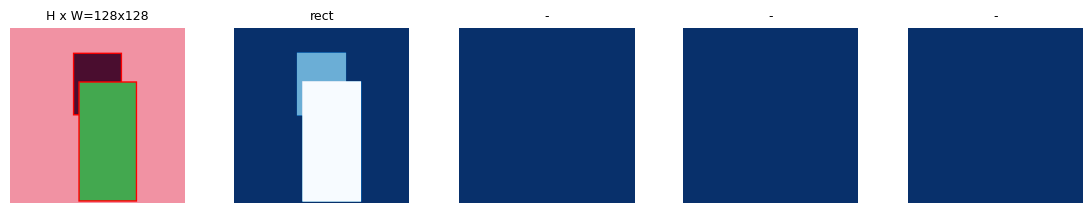

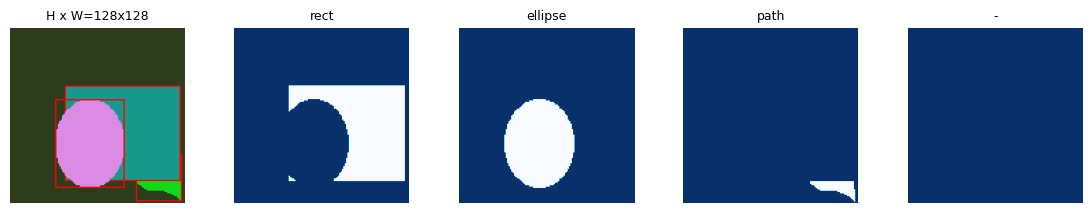

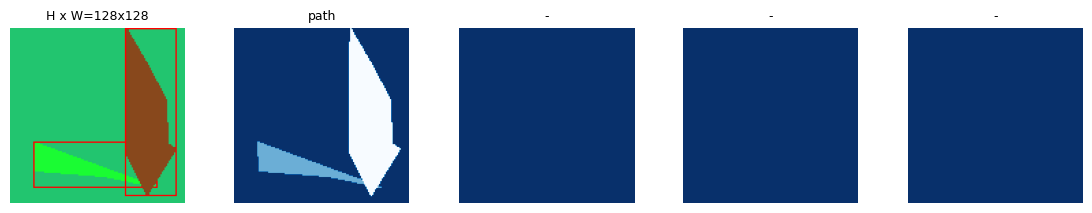

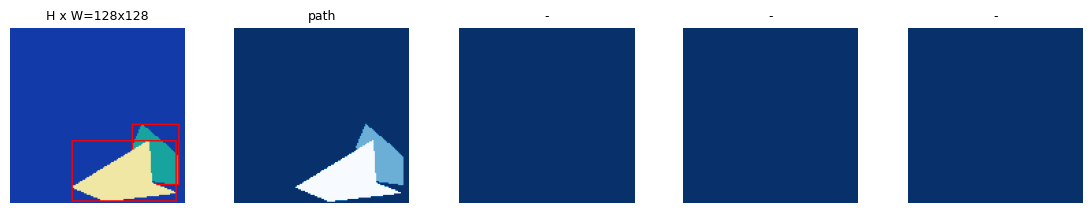

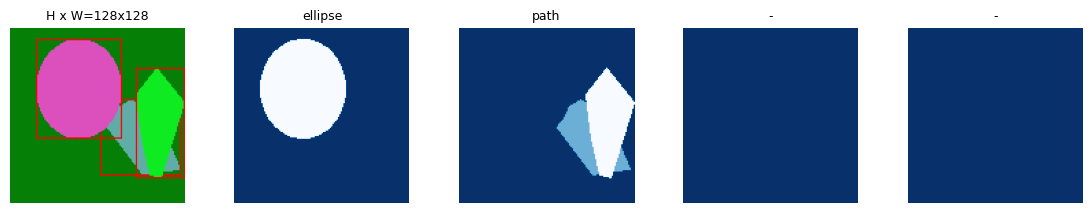

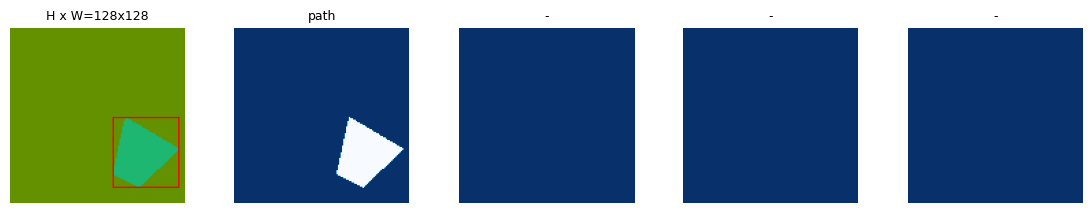

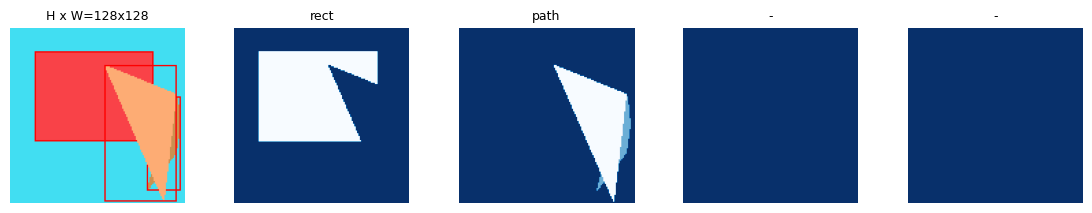

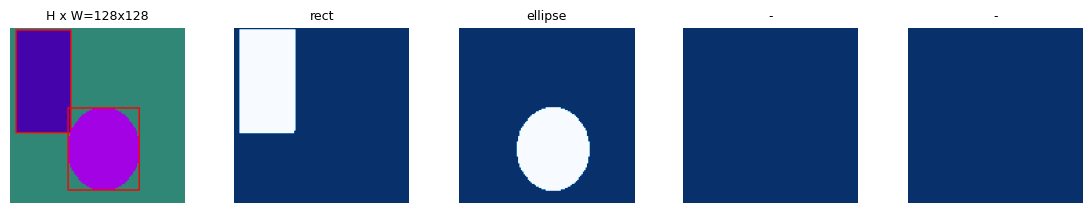

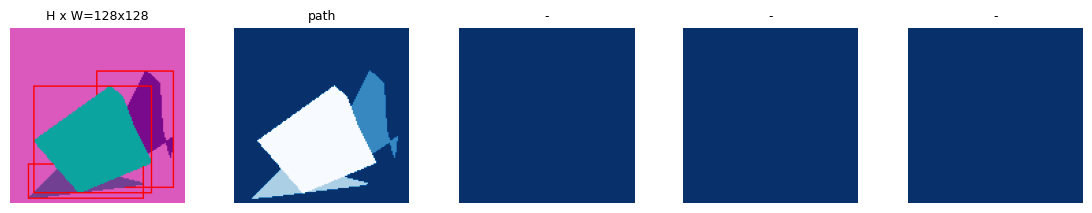

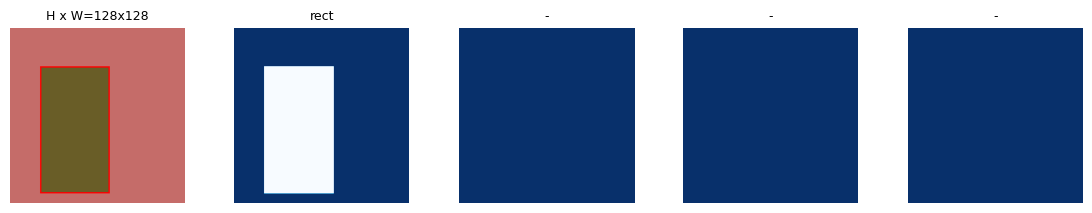

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 10)
for _image_id in image_ids:
    image = dataset_train.load_image(_image_id, True)
    mask, class_ids = dataset_train.load_mask(_image_id)
    visualize.display_top_masks(image, mask, class_ids,
                                dataset_train.class_names)  #, dataset_train.image_info[_image_id]['shapes'])

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode='training', config=config,
                          model_dir=MODEL_DIR)

2022-12-21 16:09:38.770729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 16:09:38.771857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-21 16:09:38.771896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 5300M
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
Rect


In [9]:
# Which weights to start with?
init_with = 'coco'  # imagenet, coco, or last

if init_with == 'imagenet':
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == 'coco':
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc',
                                'mrcnn_bbox', 'mrcnn_mask'])
elif init_with == 'last':
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers='all'` to train all layers.

In [10]:
# Train the head branches
# Passing layers='heads' freezes all layers except the head
# layers. You can also pass a regular expression to selectz
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='vectors')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/umbo/Projects/VectorAIzer/logs/shapes20221221T1609/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
vectors                (VectorsLayer)
n workers used: 12
Layer VectorsLayer has arguments ['self', 'config']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


/var/folders/qq/1kcdwlmn5wbfm9x7kldmhc580000gn/T/ipykernel_48688/3303499860.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return masks.astype(np.bool), _class_ids.astype(np.int32)
/var/folders/qq/1kcdwlmn5wbfm9x7kldmhc580000gn/T/ipykernel_48688/3303499860.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return masks.astype(np.bool), _cla

Shapes: [b'[[6, 0, 49, 87], [30, 76, 97, 46], [62, 54, 33, 55], [21, 19, 79, 42]]'
 b'[[22, 60, 58, 51], [35, 37, 32, 28]]'
 b'[[67, 28, 27, 25], array([[ 98,  30],\n       [121,  62],\n       [118,  87],\n       [ 92, 119]], dtype=int32), [60, 66, 41, 33]]'
 b'[array([[ 89,  73],\n       [ 91,  65],\n       [122,  65],\n       [127,  93],\n       [ 95, 113],\n       [ 87, 127]], dtype=int32), [82, 53, 25, 31], [9, 71, 66, 32], [3, 19, 101, 102]]'
 b'[[34, 50, 31, 27], array([[ 61, 119],\n       [ 59, 107],\n       [116,  96],\n       [109, 119]], dtype=int32)]'
 b'[[2, 34, 100, 44], [96, 26, 32, 96], [41, 58, 26, 42]]'
 b'[array([[ 90, 102],\n       [ 90,  65],\n       [109,  20],\n       [118,  16],\n       [121,  25],\n       [116, 113],\n       [117, 114]], dtype=int32)]'
 b'[array([[ 74, 101],\n       [ 63,  33],\n       [124,  99],\n       [110, 121]], dtype=int32)]']
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
Rect
  1/100 [.........

KeyboardInterrupt: 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, 'mask_rcnn_shapes.h5')
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, '.h5 file name here')
model_path = model.find_last()

# Load trained weights
print('Loading weights from ', model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
_image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config,
                                                                                   _image_id)

log('original_image', original_image)
log('image_meta', image_meta)
log('gt_class_id', gt_class_id)
log('gt_bbox', gt_bbox)
log('gt_mask', gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for _image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, _image_id,
                                                                              use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                                         r['rois'], r['class_ids'], r['scores'], r['masks'])
    APs.append(AP)

print('mAP: ', np.mean(APs))
